cambiar markdown por comentarios

movies_dfp[movies_dfp['overview'].str.strip() == ""].shape[0] ???

In [763]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

In [764]:
#Agregamos la ruta de la carpeta functions
sys.path.append(os.path.abspath(os.path.join('..', 'functions')))

In [765]:
movies_dfp = pd.read_parquet('../data_post_etl/movies/movies_dataset_etl.parquet')

                                        **Metraje**                                         

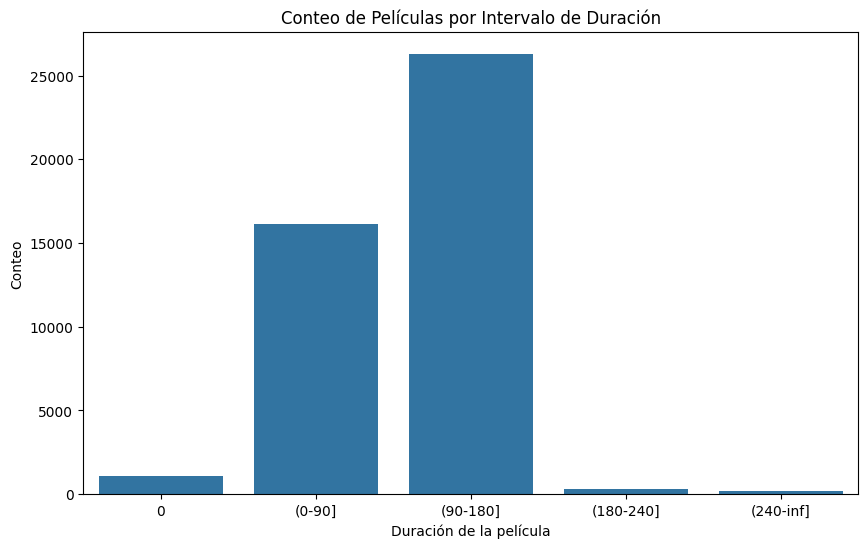

La película con la duración máxima: 1256.0
La película con la duración mínima: 0.0
La media de duración de las peliculas es de 95.13
La mediana de duración de las peliculas es de 95.0
Desviación estándar: 37.49587018454182
Coeficiente de asimetría: 5.003899688021529


In [766]:
metraje = movies_dfp['runtime'].dropna()

bins = [float('-inf'),0, 90, 180, 240, float('inf')]
labels = ['0', '(0-90]', '(90-180]', '(180-240]','(240-inf]']

# Grafico de conteo
plt.figure(figsize=(10, 6))
sns.countplot(data=movies_dfp, x=pd.cut(metraje, bins=bins))
plt.xlabel('Duración de la película')
plt.ylabel('Conteo')
plt.title('Conteo de Películas por Intervalo de Duración')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.show()

print(f'La película con la duración máxima: {max(metraje)}')
print(f'La película con la duración mínima: {min(metraje)}')
print(f'La media de duración de las peliculas es de {round(np.mean(metraje), 2)}')
print(f'La mediana de duración de las peliculas es de {np.median(metraje)}')
print(f'Desviación estándar: {np.std(metraje)}')
print(f'Coeficiente de asimetría: {metraje.skew()}')


Ya que buscaremos predecir una pelicula borraremos aquellos metrajes que superan las 4 horas considerando que pueden estar dentro del dataset miniseries o series, y en caso de ser peliculas no recomendaremos peliculas más largas de 4 horas ya que no tienden a ser muy bien aceptadas por el público

In [767]:
movies_dfp = movies_dfp[movies_dfp['runtime'] < 240]

In [768]:
# Peliculas con duración igual a 0:
len(movies_dfp[movies_dfp['runtime'] == 0])

1093

Como podemos observar hay 1478 peliculas que tienen una duración de 0 minutos. Por el valor que pueden llegar a tener esos datos, transformaremos su duración a la media de metraje

In [769]:
movies_dfp.loc[movies_dfp['runtime'] == 0, 'runtime'] = media_runtime

In [770]:
# Confirmamos la transformación:
len(movies_dfp[movies_dfp['runtime'] == 0])

0

In [771]:
#Estos cambios en los valores favorecieron a reducir el sesgo, creando una mayor simetría.
print(f'Coeficiente de asimetría: {metraje.skew()}')

Coeficiente de asimetría: 5.003899688021529


                                        **idioma**                                  

In [772]:
movies_dfp['original_language'].value_counts().head(10)

original_language
en    31669
fr     2247
ja     1335
it     1251
de      950
es      915
ru      763
hi      498
ko      442
zh      402
Name: count, dtype: int64

Observemos cuáles son las películas con mayor cantidad de idiomas originales utilizados:

In [773]:
movies_dfp['original_language'].value_counts()

original_language
en    31669
fr     2247
ja     1335
it     1251
de      950
      ...  
uz        1
mt        1
hy        1
lb        1
si        1
Name: count, Length: 89, dtype: int64

C:\Users\Julia\AppData\Local\Temp\ipykernel_4348\1594334105.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_idiomas_originales.index, y=top_idiomas_originales.values, palette='viridis')


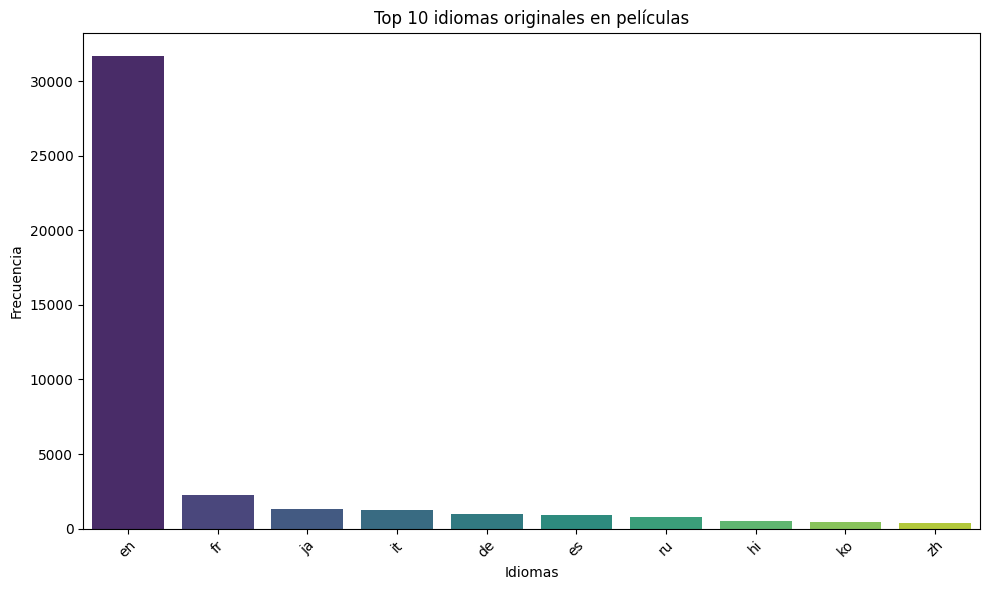

In [774]:
top_idiomas_originales = movies_dfp['original_language'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_idiomas_originales.index, y=top_idiomas_originales.values, palette='viridis')

plt.title('Top 10 idiomas originales en películas')
plt.xlabel('Idiomas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Se ve una predominancia muy clara del idioma ingles. Utilizaremos solo el top 3 + el idioma español para optimizar el modelo.

In [775]:
idiomas_seleccionados = ['en','fr','it','es']

movies_dfp = movies_dfp[movies_dfp['original_language'].isin(idiomas_seleccionados)]

Al ya estar utilizando los idiomas de las peliculas, no utilizaremos el id de los idiomas en los cuales se trabajo esa pelicula

In [776]:
movies_dfp.drop(columns='spoken_languages_id', inplace=True)

                                        **Fecha**                                           

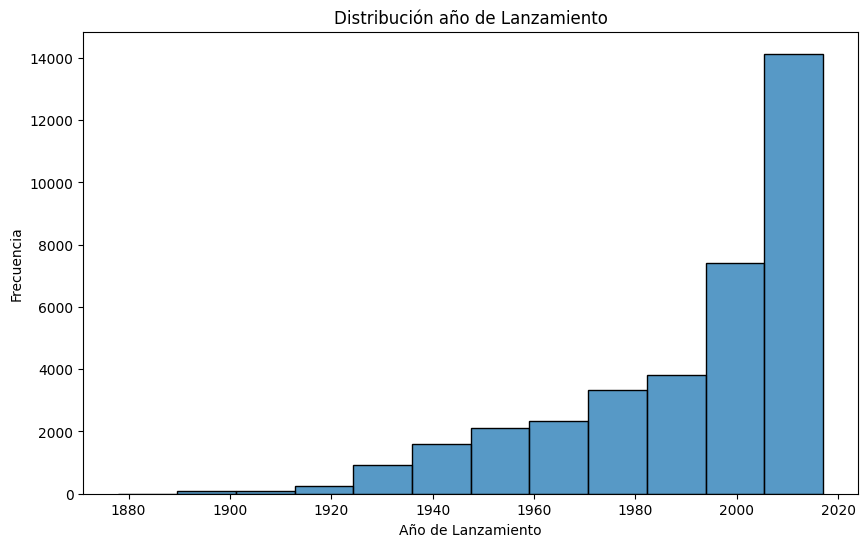

La película más nueva que hay como dato se estrenó en el año: 2017
La película más antigua que hay como dato se estrenó en el año: 1878
La media de año de estreno de una película: 1990.82
La mediana de año de estreno de una película: 2000.0
Desviación estándar: 24.654559237552377
Coeficiente de asimetría: -1.1475711374404083


In [777]:
año = movies_dfp['release_year']

plt.figure(figsize=(10,6))
sns.histplot(movies_dfp, x='release_year', bins=12)

plt.title('Distribución año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Frecuencia')

plt.show()

print(f'La película más nueva que hay como dato se estrenó en el año: {max(año)}')
print(f'La película más antigua que hay como dato se estrenó en el año: {min(año)}')
print(f'La media de año de estreno de una película: {round(np.mean(año), 2)}')
print(f'La mediana de año de estreno de una película: {np.median(año)}')
print(f'Desviación estándar: {np.std(año)}')
print(f'Coeficiente de asimetría: {año.skew()}')


Como para el modelo la popularidad va a ser un factor muy importante, considero que va a ser pertinente utilizar las peliculas a partir del 1980

In [778]:
movies_dfp = movies_dfp[movies_dfp['release_year'] > 1980]

Para el modelo no utilizaremos las fechas completas ya que solo nos interesa el año de lanzamiento

In [779]:
movies_dfp.drop(columns='release_date', inplace=True)

In [780]:
#Estos cambios en los valores favorecieron a reducir el sesgo, creando una mayor simetría.
print(f'Coeficiente de asimetría: {año.skew()}')

Coeficiente de asimetría: -1.1475711374404083


                                **Popularidad y Cantidad de Votos**                         

Para poder recomendar una pelicula, se necesita un estandar? para poder valorarla, por eso si no tienen votos y no tienen medida la popularidad procederemos a borrarlas

Procedemos a borrar las p 438 peliculas

In [781]:
movies_dfp = movies_dfp[~((movies_dfp['popularity']== 0) & (movies_dfp['vote_count'] == 0))]

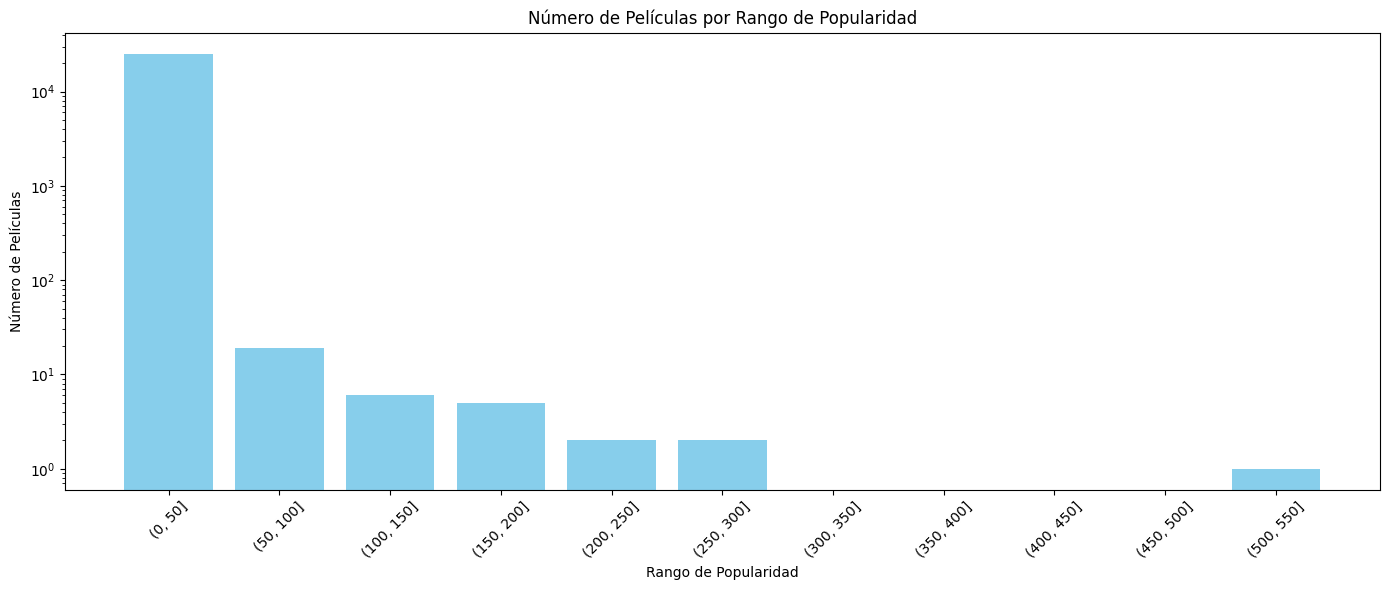

Valor máximo: 547.49
Valor mínimo: 0.0
Media: 3.8972417039303364
Mediana: 1.7
Moda: 0    0.01
Name: popularity, dtype: float64
Desviación estándar: 7.522558617618867
Coeficiente de asimetría: 26.02483710506211


In [782]:
pop = movies_dfp['popularity']

# Agrupamos 'popularity' en intervalos más amplios para una mejor visualización
bins = range(0, int(movies_dfp['popularity'].max()) + 50, 50)  # Intervalos de 50
popularity_binned = pd.cut(movies_dfp['popularity'], bins=bins).value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(14, 6))
plt.bar(popularity_binned.index.astype(str), popularity_binned.values, color='skyblue')
plt.xlabel('Rango de Popularidad')
plt.ylabel('Número de Películas')
plt.title('Número de Películas por Rango de Popularidad')

# Escala logarítmica para mejorar la visibilidad de los datos sesgados
plt.yscale('log')

plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()



print(f'Valor máximo: {max(pop)}')
print(f'Valor mínimo: {min(pop)}')
print(f'Media: {np.mean(pop)}')
print(f'Mediana: {np.median(pop)}')
print(f'Moda: {pop.mode()}')
print(f'Desviación estándar: {np.std(pop)}')
print(f'Coeficiente de asimetría: {pop.skew()}')

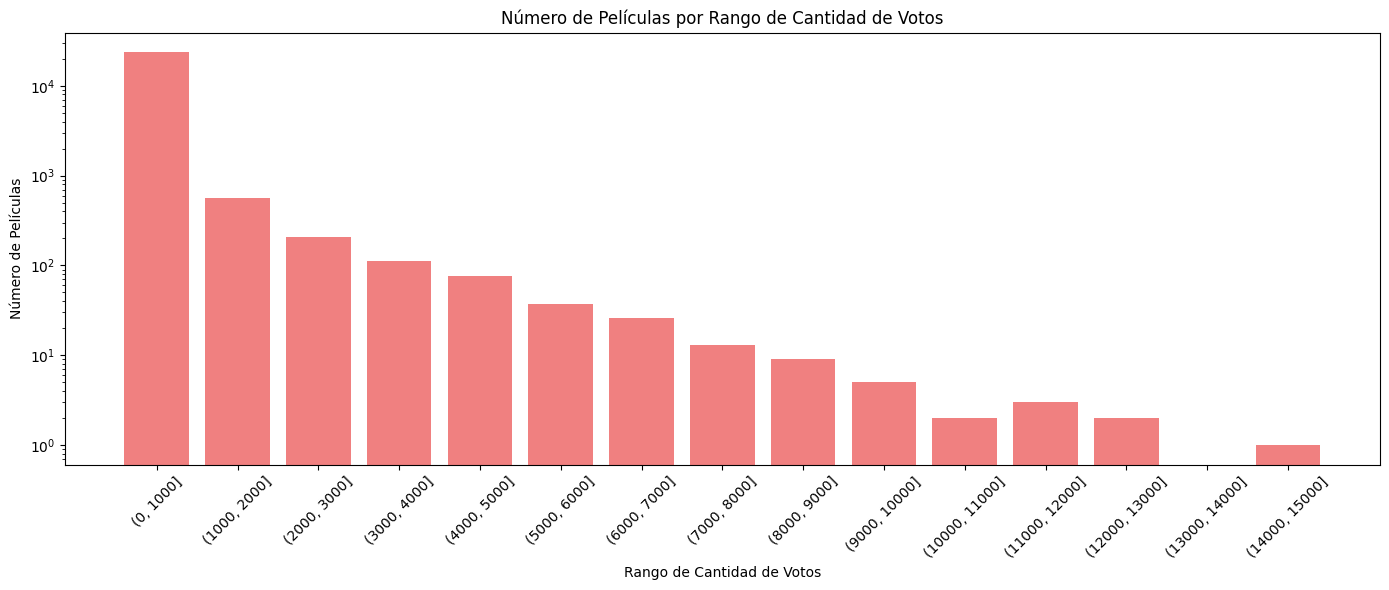

Valor máximo: 14075
Valor mínimo: 0
Media: 173.2929316701969
Mediana: 15.0
Moda: 0    1
Name: vote_count, dtype: int64
Desviación estándar: 635.739065764413
Coeficiente de asimetría: 8.10851928050913


In [783]:
cantidad_votos = movies_dfp['vote_count']

# Agrupamos 'vote_count' en intervalos más amplios para una mejor visualización
bins = range(0, int(movies_dfp['vote_count'].max()) + 1000, 1000)  # Intervalos de 1000
vote_count_binned = pd.cut(movies_dfp['vote_count'], bins=bins).value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(14, 6))
plt.bar(vote_count_binned.index.astype(str), vote_count_binned.values, color='lightcoral')
plt.xlabel('Rango de Cantidad de Votos')
plt.ylabel('Número de Películas')
plt.title('Número de Películas por Rango de Cantidad de Votos')

# Mostrar las etiquetas del eje x
plt.xticks(rotation=45)  # Opcional: Rota las etiquetas para una mejor visualización

# Escala logarítmica para mejorar la visibilidad de los datos sesgados
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f'Valor máximo: {max(cantidad_votos)}')
print(f'Valor mínimo: {min(cantidad_votos)}')
print(f'Media: {np.mean(cantidad_votos)}')
print(f'Mediana: {np.median(cantidad_votos)}')
print(f'Moda: {(cantidad_votos.mode())}')
print(f'Desviación estándar: {np.std(cantidad_votos)}')
print(f'Coeficiente de asimetría: {cantidad_votos.skew()}')


In [784]:
movies_dfp[['vote_count', 'popularity']].describe()

,vote_count,popularity
count,25494.000000,25494.000000
mean,173.292932,3.897242
std,635.751535,7.522706
min,0.000000,0.000000
25%,4.000000,0.550000
50%,15.000000,1.700000
75%,65.000000,5.830000
max,14075.000000,547.490000


Podemos observar qeu tanto la cantidad de votos y la popularidad(elementos muy valiosos para recomendar peliculas) tienen un sesgo positivo muy marcado. Pero las peliculas muy populares y muy votadas nos son valiosas así que las mantendremos


Por otro lado procederemos a quedarnos con los percentiles superiores a Q1 ya que preferimos no utilizar las peliculas poco votadas y muy poco populares

In [785]:
movies_dfp = movies_dfp[(movies_dfp['vote_count'] > 4) & 
            (movies_dfp['popularity'] > 0.55)]

además nos quedaremso solamente con la cantidad de votos y desestimaderos la medias.

desestimaremos los los id del pais de las productoras ya que tampoco utilizaremos esa tabla en el modelo, además por el hecho de que no nos sirven los id para el modelo sacaremos también el de btc_id

In [786]:
movies_dfp.drop(columns=['production_countries_id', 'btc_id'], inplace=True)

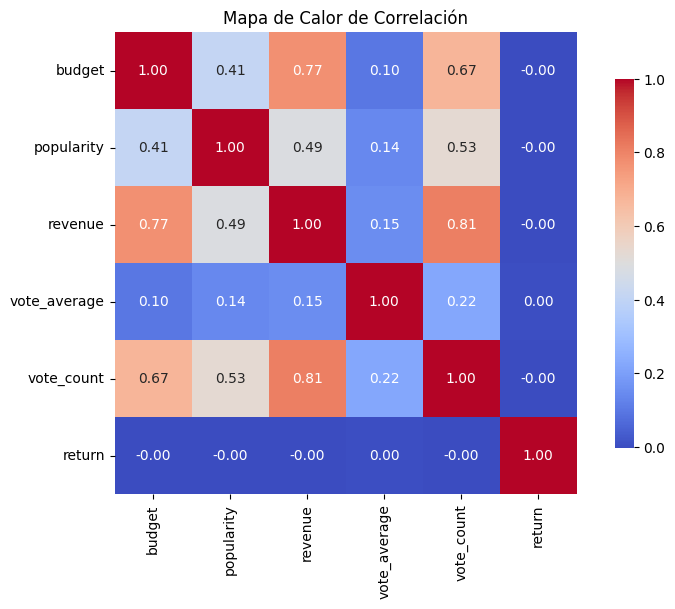

In [787]:
cols_mapa_calor = movies_dfp[['budget', 'popularity', 'revenue', 'vote_average', 'vote_count', 'return']]

matriz_correlación = cols_mapa_calor.corr()
plt.figure(figsize=(10,6))
sns.heatmap(matriz_correlación, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Agregar título
plt.title('Mapa de Calor de Correlación')
plt.show()

En primera instancia se peude observar que mientras mayor rédito en la palicula hay una tendencia a que se más popular y una mayor tendencia a dicha película sea votada, además un gran redito por lo general, es predecedida por una gran inversión. Lo que parecería indicar que mientras más inversión es más probable que haya una mayor ganancia.

También podemos observar que la variable return tiene una correlación nula con el resto de variables

Por ello en cuanto a recursos financieros implica nos quedaremos con la variable revenue(ganancia) para el desarrollo del modelo ya que tiene mayor poder explicativo en cuanto a las tendencias.

In [788]:
movies_dfp.drop(columns=['budget', 'return'], inplace=True)

                                **Preprocesamiento de??**cambiar de archivo?                                                                                           

de aca para abajo ver que cambiar

In [789]:
import nltk

nltk.data.path.append('b:/proyecto_individual_1/venv') 

# Descargar recursos necesarios
nltk.download('punkt_tab', download_dir='b:/proyecto_individual_1/venv')
nltk.download('stopwords', download_dir='b:/proyecto_individual_1/venv')
nltk.download('wordnet', download_dir='b:/proyecto_individual_1/venv')
nltk.download('averaged_perceptron_tagger_eng', download_dir='b:/proyecto_individual_1/venv')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [790]:
from tokenizador import tokenizar

In [791]:
movies_dfp['overview'] = movies_dfp['overview'].apply(tokenizar)

In [792]:
production_companies = pd.read_parquet('../data_post_etl/movies/production_companies.parquet')

In [793]:
production_companies.columns

Index(['name', 'production_companies_id'], dtype='object')

In [794]:
import re
production_companies['name'] = production_companies['name'].apply(
    lambda x: re.sub(r'[^\w\s]', '', re.sub(r'\s+', ' ', x.lower())).strip()
)

In [797]:
# Contar el número de filas antes del filtrado
filas_antes = len(production_companies)

# Filtrar el DataFrame
production_companies = production_companies[production_companies['production_companies_id'].isin(movies_dfp['production_companies_id'])]

# Contar el número de filas después del filtrado
filas_despues = len(production_companies)

# Calcular cuántas filas se eliminaron
filas_eliminadas = filas_antes - filas_despues

print(f'Número de filas eliminadas: {filas_eliminadas}')


Número de filas eliminadas: 31258
